# Time Series Illustration: Monthly Sales of Champagne Data: XGboost



In [ ]:

### Just to remove warnings to prettify the notebook.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Teaching/ML2_MSDS2026FT/Notebook1_ARIMA/'

Mounted at /content/drive


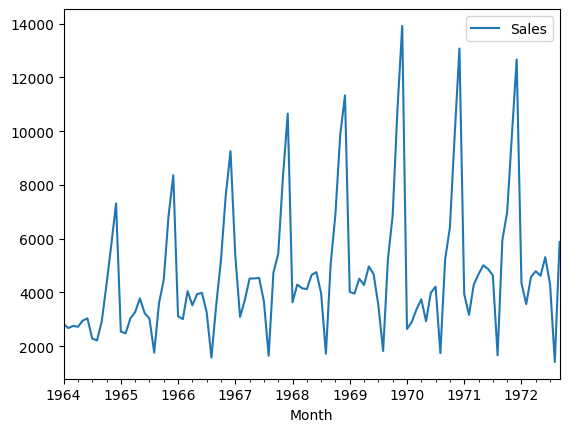

In [ ]:
df = pd.read_csv(data_dir+'champagne.csv')

# separate out a validation dataset
from pandas import read_csv

# Load the series without 'squeeze' parameter
series = read_csv(data_dir + 'champagne.csv', header=0, index_col=0, parse_dates=True)

from matplotlib import pyplot
%matplotlib inline
series.plot()
pyplot.show()

In [ ]:
df

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import datetime

# Load the dataset

series = read_csv(data_dir + 'dataset.csv', header=None, index_col=0, parse_dates=True)
series.columns = ['Sales']

# Fix frequency issue by explicitly setting it
if not series.index.freq:
    series.index = pd.date_range(start=series.index[0], periods=len(series), freq='MS')  # Monthly frequency

# Define 1-year forecast period (12 months)
forecast_horizon = 12

# Prepare the dataset for supervised learning (for XGBoost)
def create_features(df, label=None):
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    X = df[['year', 'month', 'dayofyear', 'dayofweek', 'quarter']]
    if label:
        y = df[label]
        return X, y
    return X

# Use the entire dataset minus the last 12 months for training, and forecast the last 12 months
train_size = len(series) - forecast_horizon
train, forecast_period = series[:train_size], series[train_size:]

# Create features for training and forecasting
X_train, y_train = create_features(train, label='Sales')
X_forecast = create_features(forecast_period)

# GridSearchCV to find the optimal XGBoost model
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = XGBRegressor()

# Use TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the optimal XGBoost model
optimal_xgb = XGBRegressor(**best_params)
optimal_xgb.fit(X_train, y_train)

# Predict the forecast period (last 12 months)
xgboost_forecast = optimal_xgb.predict(X_forecast[:forecast_horizon])


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


# Compare with plot of Notebook 1 using ARIMA for the time series forecast.

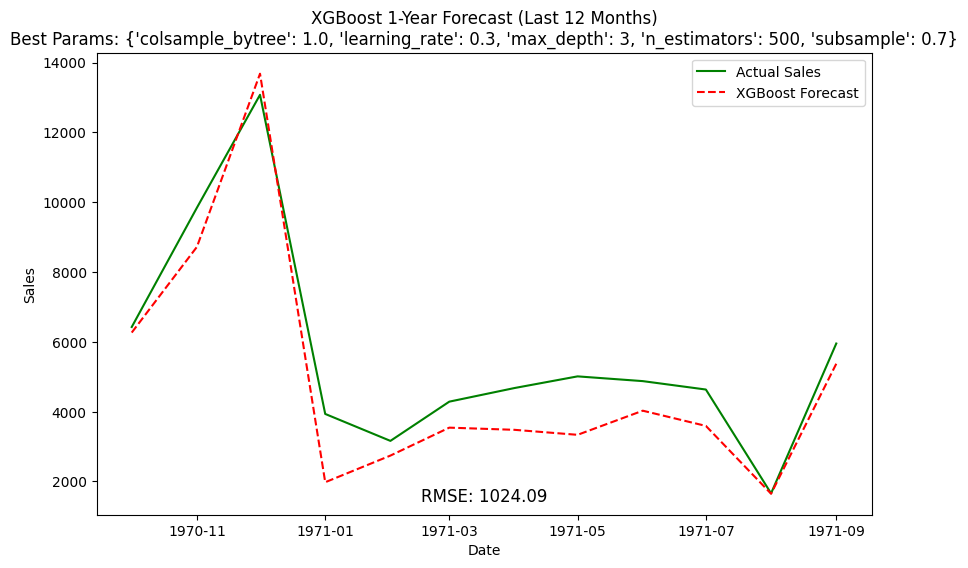

RMSE for XGBoost 1-Year Forecast: 1024.0878868534674


In [ ]:
# Plot the forecast results for the test set (actual sales vs. forecast)
plt.figure(figsize=(10, 6))

# Plot the actual sales data for the forecast period (last 12 months) in green.
plt.plot(forecast_period.index[:forecast_horizon], forecast_period['Sales'][:forecast_horizon], label='Actual Sales', color='green')

# Plot the XGBoost forecasted sales data for the same 12-month period in red with a dashed line.
plt.plot(forecast_period.index[:forecast_horizon], xgboost_forecast, label='XGBoost Forecast', linestyle='--', color='red')

# Set the x-axis label to "Date" and the y-axis label to "Sales".
plt.xlabel('Date')
plt.ylabel('Sales')

# Add a plot title, mentioning the XGBoost forecast for the last 12 months and showing the best parameters used in the model.
plt.title(f'XGBoost 1-Year Forecast (Last 12 Months)\nBest Params: {best_params}')

# Add a legend to differentiate between actual sales and forecasted sales.
plt.legend()

# Display RMSE on the plot
rmse = np.sqrt(mean_squared_error(forecast_period['Sales'][:forecast_horizon], xgboost_forecast))
plt.text(0.5, 0.02, f'RMSE: {rmse:.2f}', horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=12)

plt.show()

# Print RMSE
print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")


This result outperforms the RMSE of 1561 obtained using ARIMA in Notebook 1, highlighting ARIMA’s limitations compared to more advanced models. In general, ARIMA tends to be less effective than its seasonal counterpart, SARIMA, as well as more modern machine learning algorithms, such as gradient boosting models described above. In ML3, you will explore how deep learning techniques like LSTMs and transformers often surpass even these models, which excel at capturing complex patterns in time series data.

#Another Model

RMSE for rolling forecast: 796.9902894069539


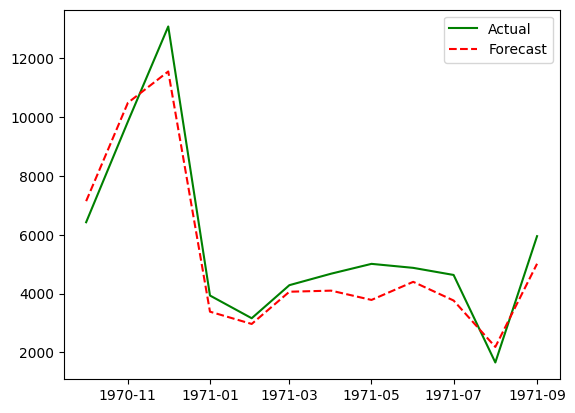

In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
series = read_csv(data_dir + 'dataset.csv', header=None, index_col=0, parse_dates=True)
series.columns = ['Sales']

# Fix frequency issue by explicitly setting it
if not series.index.freq:
    series.index = pd.date_range(start=series.index[0], periods=len(series), freq='MS')  # Monthly frequency

# Define 1-year forecast period (12 months)
forecast_horizon = 12
window_size = 12  # 12 months for rolling window

# Function to create lagged features (12 previous months)
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i].values)  # Previous 12 months
        y.append(data[i])  # Next month's value (target)
    return np.array(X), np.array(y)

# Function to run the rolling forecast with a 12-month lagged window
def rolling_forecast_lagged(series, forecast_horizon, window_size=12):
    train_size = len(series) - forecast_horizon
    train, test = series[:train_size], series[train_size:]

    predictions = []

    # Convert the training data to lagged features
    X_train, y_train = create_lagged_features(train['Sales'], window_size)

    for i in range(forecast_horizon):
        # Create feature for the next point to forecast using the last 12 months
        X_next = series['Sales'][train_size-window_size+i:train_size+i].values.reshape(1, -1)

        # Initialize XGBoost model
        xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, subsample=0.7, colsample_bytree=0.7)

        # Train the model
        xgb_model.fit(X_train, y_train)

        # Forecast the next point
        next_forecast = xgb_model.predict(X_next)
        predictions.append(next_forecast[0])

        # Update training set with actual observed value after the forecast
        X_train = np.vstack([X_train, X_next])
        y_train = np.append(y_train, test['Sales'].iloc[i])

    return predictions, test['Sales']

# Perform rolling forecast
xgboost_forecast, actuals = rolling_forecast_lagged(series, forecast_horizon)

# Calculate RMSE for the rolling forecast
rmse = np.sqrt(mean_squared_error(actuals, xgboost_forecast))
print(f"RMSE for rolling forecast: {rmse}")

# Plot the results
plt.plot(series.index[-forecast_horizon:], actuals, label='Actual', color='green')
plt.plot(series.index[-forecast_horizon:], xgboost_forecast, label='Forecast',linestyle='--', color='red')
plt.legend()
plt.show()
